# Bike Rental Analysis and Prediction

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,ShuffleSplit
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

A lot of cities around the world are implementing bike rental stations as part of their integrated transport systems. Additional to increasing the available options of moving around the city, these systems bring a lot of positive consequences to urban spaces, like reducing gas emissions, traffic jams and improving the health of citizens. In order to have a system working, it's important to have the correct capacity for satisfying the needs of the users. This correct capacity requires continuous maintenance, relocation and acquisition of new bikes.

The goal of this project is using data available from [Washington DC's bike sharing system](https://secure.capitalbikeshare.com/map/) and some additional information gathered, for predicting the amount of bicycles needed per day on some temporal and weather conditions. This type of predictions help the system managers to handle their capacity, program better maintenance times and keep their user rate increasing. 

## Data Download

For this project I used the data from [Bike Sharing Dataset Data Set](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), which is part of a paper from Fanaee-T, Hadi, and Gama, Joao, called 'Event labeling combining ensemble detectors and background knowledge'. Since the data was in `.zip` format, I downloaded and put it in the [Data](./data/) folder of this repository.

In [16]:
day = pd.read_csv('data/day.csv',sep=',')
hour = pd.read_csv('data/hour.csv',sep=',')

In [17]:
day.shape

(731, 16)

This dataset has 731 observations and 16 attributes, which 3 of them are response variables. Previous to any analysis, I will split the data and keep the test data apart, respecting the golden rule of machine learning. I decided to work with the `day` dataset, which groups the hourly observations into days.

In [18]:
day_train,day_test = train_test_split(day,test_size=0.3)

## Data Cleaning and Wrangling

Now I divide the original dataset into the explanatory and the response variables. I also dropped the feature `instant`, which is just a database id for the day information:

In [19]:
day_train_y = day_train[['casual','registered','cnt']]
day_train_x = day_train[day_train.columns.difference(['casual','registered','cnt','instant','dteday'])]
#day_train_x = day_train['temp']

In [20]:
day_test_y = day_test[['casual','registered','cnt']]
day_test_x = day_test[day_test.columns.difference(['casual','registered','cnt','instant','dteday'])]
#day_test_x = day_test['temp']

Now, it's important to prepare the dataset for using it with Scikit Learn. I will convert it from the Pandas dataframe into compatible numpy arrays.

In [11]:
X_train = pd.DataFrame.as_matrix(day_train_x)

#Extracting the response variable for the total rentals
y_train_t = day_train_y['cnt']
y_train_t = pd.DataFrame.as_matrix(y_train_t)

#Extracting the response variable for the casual users
y_train_c = day_train_y['casual']
y_train_c = pd.DataFrame.as_matrix(y_train_c)

#Extracting the response variable for the registered users
y_train_r = day_train_y['registered']
y_train_r = pd.DataFrame.as_matrix(y_train_r)

In [12]:
X_test = pd.DataFrame.as_matrix(day_test_x)

#Extracting the response variable for the total rentals
y_test_t = day_test_y['cnt']
y_test_t = pd.DataFrame.as_matrix(y_test_t)

#Extracting the response variable for the casual users
y_test_c = day_test_y['casual']
y_test_c = pd.DataFrame.as_matrix(y_test_c)

#Extracting the response variable for the registered users
y_test_r = day_test_y['registered']
y_test_r = pd.DataFrame.as_matrix(y_test_r)

## Exploratory Data Analysis

The idea with the Exploratory Data Analysis (EDA) is finding some general patterns in the dataset, which will be contrasted with the results of the models. The features are divided in two groups (I used the descriptions  [Dataset Site](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset):

- **Weather features**: each observation has the following features computed by the authors and combined with the information from the bike sharing system:

    + weathersit : 
        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    - temp : Normalized temperature in Celsius.
    - atemp: Normalized feeling temperature in Celsius.
    - hum: Normalized humidity.
    - windspeed: Normalized wind speed. The values are divided to 67 (max)
    

- **Temporal features**: the authors used the following information available from the bike sharing system.

    - instant: record index
    - dteday : date
    - season : season (1:springer, 2:summer, 3:fall, 4:winter)
    - yr : year (0: 2011, 1:2012)
    - mnth : month ( 1 to 12)
    - hr : hour (0 to 23)
    - holiday : weather day is holiday or not (extracted from [Web Link])
    - weekday : day of the week
    - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
    
    
- **Response variables**:

    - casual: count of casual users
    - registered: count of registered users
    - cnt: count of total rental bikes including both casual and registered

The idea with this EDA is observing the relations between the two groups of features with these response variables.

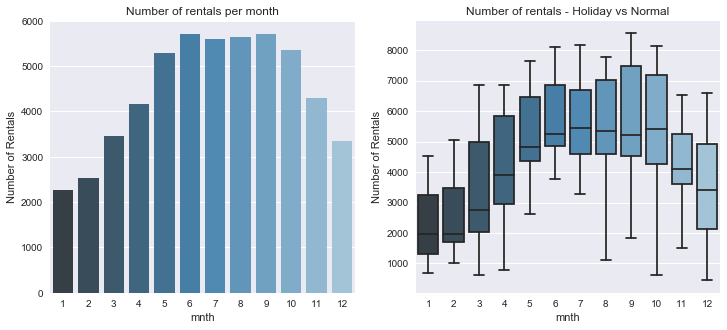

In [13]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.barplot(x="mnth", y="cnt", data=day_train,ax=axes[0],ci=None,palette="Blues_d")
axes[0].set_title('Number of rentals per month')
axes[0].set_ylabel('Number of Rentals')
sns.boxplot(  y="cnt", x= "mnth", data=day_train,  orient='v' , ax=axes[1],palette="Blues_d")
axes[1].set_title('Number of rentals - Holiday vs Normal')
axes[1].set_ylabel('Number of Rentals')
plt.show()

We can see from the previous plots that the months with the highest number of rentals are from May to September (summer months), and the months with the lowest amount of rentals are the winter months. Even though, some of the summer months like August and September have wide ranges in the rentals per day. Just observing this plot we can see that the most important months for the system to operate well are May, June and July, where the minimum number of rentals per day is high.

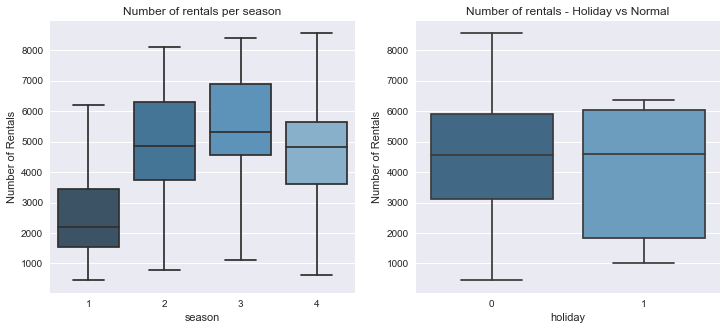

In [15]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.boxplot(  y="cnt", x= "season", data=day_train,  orient='v' , ax=axes[0],palette="Blues_d")
axes[0].set_title('Number of rentals per season')
axes[0].set_ylabel('Number of Rentals')
sns.boxplot(  y="cnt", x= "holiday", data=day_train,  orient='v' , ax=axes[1],palette="Blues_d")
axes[1].set_title('Number of rentals - Holiday vs Normal')
axes[1].set_ylabel('Number of Rentals')
plt.show()

If we analyze the rentals by season instead that by month, we can see the same conclusions, summer and begining of fall months are crucial for the operation of the system.

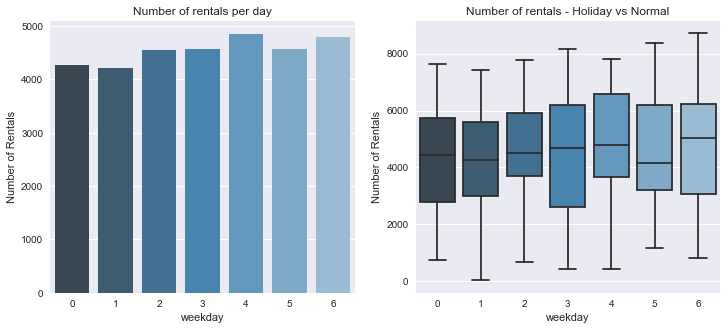

In [118]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.barplot(x="weekday", y="cnt", data=day_train,ax=axes[0],ci=None,palette="Blues_d")
axes[0].set_title('Number of rentals per day')
axes[0].set_ylabel('Number of Rentals')
sns.boxplot(y="cnt", x= "weekday", data=day_train,  orient='v' , ax=axes[1],palette="Blues_d")
axes[1].set_title('Number of rentals - Holiday vs Normal')
axes[1].set_ylabel('Number of Rentals')
plt.show()

The number of rentals per day is almost constant, with no significant differences in the number of rentals on the different days of the week. Until now we have identified two insights in our data: 

- Summer months are more attractive for using bikes than wet winter months.
- The days of the week have similar renting patterns.

Now we will perform the similar analysis but exploring the different types of users, casual and registered.

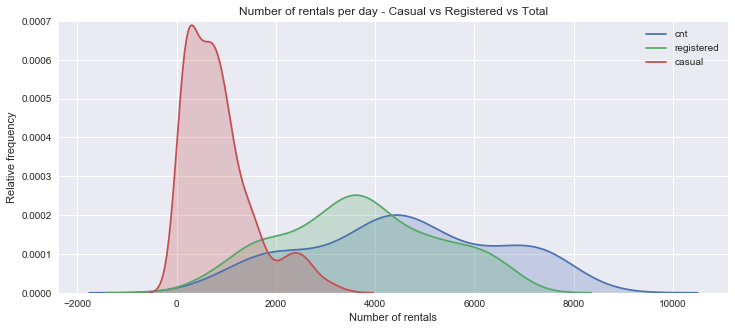

In [95]:
plt.figure(figsize=(12,5))
plt.title("Number of rentals per day - Casual vs Registered vs Total")
sns.kdeplot(day_train["cnt"], shade=True,legend=True)
sns.kdeplot(day_train["registered"], shade=True,legend=True)
sns.kdeplot(day_train["casual"], shade=True,legend=True)
plt.ylim(0,0.0007)
plt.xlabel("Number of rentals")
plt.ylabel("Relative frequency")
plt.show()

Almost all the days observed, the number of rentals by registered users was higher than the number of rentals by casual users. The number of rentals by casual users was more constant and centered around their mean, while in the registered users the variance of the number of rentals was higher. We can see both conclusion from the previous plot.

Now, we will compare the other block of features, weather, with the different types of users:

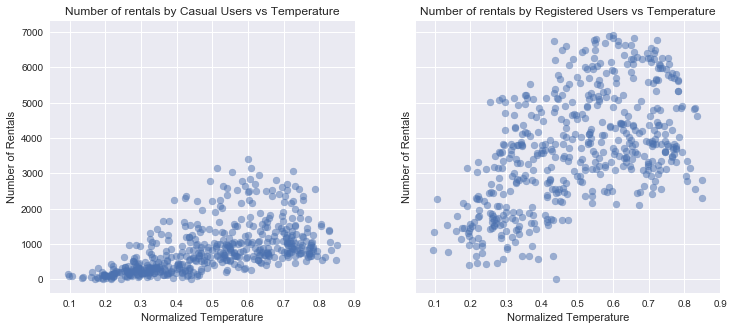

In [86]:
f, axarr = plt.subplots(1,2, sharey=True,figsize=(12,5))
axarr[0].scatter(day_train['temp'], day_train['casual'], alpha=0.5,label="Test Data")
axarr[0].set_title('Number of rentals by Casual Users vs Temperature')
axarr[0].set_xlabel('Normalized Temperature')
axarr[0].set_ylabel('Number of Rentals')
axarr[1].scatter(day_train['temp'], day_train['registered'], alpha=0.5,label="Test Data")
axarr[1].set_title('Number of rentals by Registered Users vs Temperature')
axarr[1].set_xlabel('Normalized Temperature')
axarr[1].set_ylabel('Number of Rentals')
plt.show()

From the previous scatterplots we can see that the relationship between temperature and total number of rentals is different depending on the type of user. The casual users, possibly tourists, have a slightly increasing number of rentals when the weather is warmer. On the other hand, registered users are highly influenced by the weather for deciding to rent the bikes. This insight is relevant for the model fitting section, because graphically we can say that both groups of users have different patterns.

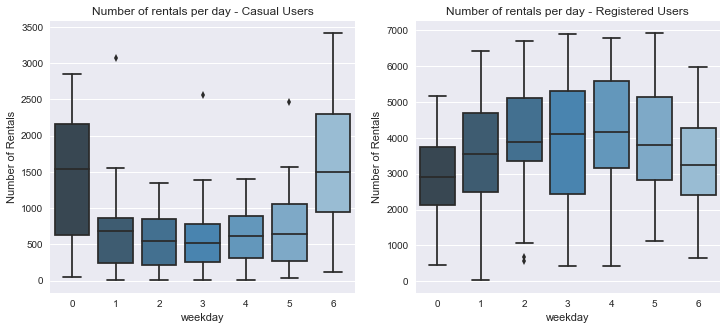

In [120]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.boxplot(y="casual", x= "weekday", data=day_train,  orient='v' , ax=axes[0],palette="Blues_d")
axes[0].set_title('Number of rentals per day - Casual Users')
axes[0].set_ylabel('Number of Rentals')
sns.boxplot(y="registered", x= "weekday", data=day_train,  orient='v' , ax=axes[1],palette="Blues_d")
axes[1].set_title('Number of rentals per day - Registered Users')
axes[1].set_ylabel('Number of Rentals')
plt.show()

There are even more differences between Casual and Registered users. From the previous boxplots we can see that casual users rent their bikes mainly on weekends, while registered users rent them on working days. This tells us more about the difference of both groups. Casual users use the bikes for pleasure and maybe most of them are tourists. On the other hand registered users use them as a transport system for their daily commute. Even though we don't have information about the users, this data exploration tells us a lot about them. For this reason in the following section we need to treat them differently.

For this EDA, I also include some summary tables of the explanatory and response variables:

In [18]:
day_train_y.describe()

,casual,registered,cnt
count,511.000000,511.000000,511.000000
mean,860.168297,3697.608611,4557.776908
std,695.752711,1572.964501,1957.390025
min,2.000000,20.000000,22.000000
25%,315.500000,2547.000000,3178.500000
50%,699.000000,3656.000000,4509.000000
75%,1133.000000,4861.000000,6146.500000
max,3410.000000,6917.000000,8714.000000


In [22]:
day_train_x[['atemp','hum','temp','windspeed']].describe()

,atemp,hum,temp,windspeed
count,511.000000,511.000000,511.000000,511.000000
mean,0.477504,0.625971,0.499712,0.194059
std,0.163563,0.139422,0.183431,0.076553
min,0.098839,0.187917,0.096522,0.022392
25%,0.336245,0.519583,0.336250,0.140550
50%,0.497463,0.623750,0.511667,0.184092
75%,0.615233,0.728541,0.660416,0.236937
max,0.840896,0.972500,0.849167,0.507463


## Feature and Model Selection

Since the response variables in this data are numerical, the models used for explaining and predicting them should be part of the *regression* group. I will use for each user group a linear regression model without regularization, a Ridge Regression, a Lasso regression and a Random Forest Regressor.

### All Users

##### Linear Regression

In [99]:
lm_t = LinearRegression()
lm_t.fit(X_train,y_train_t)
lm_t.score(X_test,y_test_t)

0.76231138216892058

In [68]:
print(lm_t.score(X_train,y_train_t))
print(lm_t.score(X_test,y_test_t))

0.814088486462
0.762311382169


In [105]:
residuals_lm = lm_t.predict(X_test)-y_test_t
fitted_lm = lm_t.predict(X_test)

##### Ridge Regression

In [69]:
alpha_values = np.arange(0.05, 20, 0.1)
r_t = RidgeCV()
r_t.fit(X_train,y_train_t)
r_t.alpha_

1.0

In [70]:
print(r_t.score(X_train,y_train_t))
print(r_t.score(X_test,y_test_t))

0.813165752823
0.757242971674


In [107]:
residuals_r = r_t.predict(X_test)-y_test_r
fitted_r = r_t.predict(X_test)

##### Lasso Regression

las_t = LassoCV()
las_t.fit(X_train,y_train_t)
las_t.alpha_

In [72]:
print(las_t.score(X_train,y_train_t))
print(las_t.score(X_test,y_test_t))

0.813603487058
0.759367506654


In [108]:
residuals_las = las_t.predict(X_test)-y_test_t
fitted_las = las_t.predict(X_test)

##### Random Forest Regressor

In [73]:
rf_t = RandomForestRegressor(max_depth=20, random_state=12)
rf_t.fit(X_train, y_train_t)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=12, verbose=0, warm_start=False)

In [74]:
print(rf_t.score(X_train,y_train_t))
print(rf_t.score(X_test,y_test_t))

0.976543875981
0.857729707279


| Item  | Linear Regression  | Ridge  | Lasso  | Random Forest Regressor |
|:-:|:-:|:-:|:-:|:-:|
| Training Score  | 0.81  | 0.81  | 0.81  | 0.97 |
| Validation Score  | 0.76  | 0.76  | 0.76  | 0.86 |
| Non-zero coefficients  | 11  | 11  | 11  | NA |

### Registered Users

##### Linear Regression

In [42]:
lm_r = LinearRegression()
lm_r.fit(X_train,y_train_r)

0.78827488256853617

In [78]:
print(lm_r.score(X_train,y_train_r))
print(lm_r.score(X_test,y_test_r))

0.825310222349
0.788274882569


##### Ridge Regression

In [79]:
alpha_values = np.arange(0.05, 20, 0.1)
r_r = RidgeCV()
r_r.fit(X_train,y_train_r)
r_r.alpha_

1.0

In [80]:
print(r_r.score(X_train,y_train_r))
print(r_r.score(X_test,y_test_r))

0.824755429587
0.784626609995


##### Lasso Regression

In [47]:
las_r = LassoCV()
las_r.fit(X_train,y_train_r)
las_r.alpha_

1.6772012974827766

In [82]:
print(las_r.score(X_train,y_train_r))
print(las_r.score(X_test,y_test_r))

0.824827813138
0.785053188706


##### Random Forest Regressor

In [84]:
rf_r = RandomForestRegressor(max_depth=20, random_state=12)
rf_r.fit(X_train, y_train_r)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=12, verbose=0, warm_start=False)

In [85]:
print(rf_r.score(X_train,y_train_r))
print(rf_r.score(X_test,y_test_r))

0.973508318756
0.830461045727


| Item  | Linear Regression  | Ridge  | Lasso  | Random Forest Regressor |
|:-:|:-:|:-:|:-:|:-:|
| Training Score  | 0.83  | 0.82  | 0.82  | 0.97 |
| Validation Score  | 0.79  | 0.79  | 0.79  | 0.83 |
| Non-zero coefficients  | 11  | 11  | 11  | NA |

### Casual Users

##### Linear Regression

In [93]:
lm_c = LinearRegression()
lm_c.fit(X_train,y_train_c)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [94]:
print(lm_c.score(X_train,y_train_c))
print(lm_c.score(X_test,y_test_c))

0.692180308299
0.673912375057


##### Ridge Regression

In [56]:
alpha_values = np.arange(0.05, 20, 0.1)
r_c = RidgeCV()
r_c.fit(X_train,y_train_c)
r_c.alpha_

1.0

In [95]:
print(r_c.score(X_train,y_train_c))
print(r_c.score(X_test,y_test_c))

0.690816812999
0.670293802249


##### Lasso Regression

In [58]:
las_c = LassoCV()
las_c.fit(X_train,y_train_c)
las_c.alpha_

0.38707393507224619

In [96]:
print(las_c.score(X_train,y_train_c))
print(las_c.score(X_test,y_test_c))

0.692023796988
0.672895456515


##### Random Forest Regressor

In [98]:
rf_c = RandomForestRegressor(max_depth=20, random_state=12)
rf_c.fit(X_train, y_train_c)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=12, verbose=0, warm_start=False)

In [97]:
print(rf_c.score(X_train,y_train_c))
print(rf_c.score(X_test,y_test_c))

0.963903094853
0.822136630804


| Item  | Linear Regression  | Ridge  | Lasso  | Random Forest Regressor |
|:-:|:-:|:-:|:-:|:-:|
| Training Score  | 0.69  | 0.69  | 0.69  | 0.96 |
| Validation Score  | 0.67  | 0.67  | 0.67  | 0.82 |
| Non-zero coefficients  | 11  | 11  | 11  | NA |

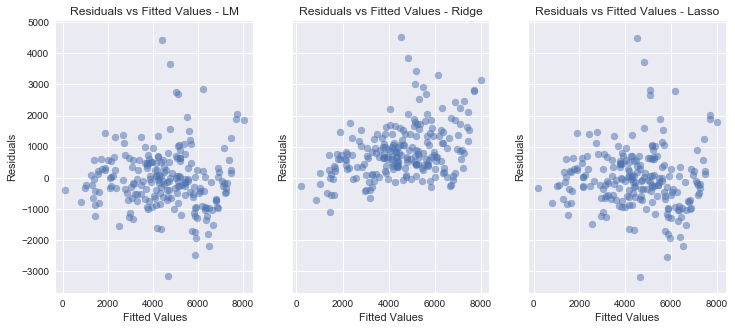

In [110]:
f, axarr = plt.subplots(1,3, sharey=True,figsize=(12,5))
axarr[0].scatter(fitted_lm, residuals_lm, alpha=0.5,label="Test Data")
axarr[0].set_title('Residuals vs Fitted Values - LM')
axarr[0].set_xlabel('Fitted Values')
axarr[0].set_ylabel('Residuals')
axarr[1].scatter(fitted_r, residuals_r, alpha=0.5,label="Test Data")
axarr[1].set_title('Residuals vs Fitted Values - Ridge')
axarr[1].set_xlabel('Fitted Values')
axarr[1].set_ylabel('Residuals')
axarr[2].scatter(fitted_las, residuals_las, alpha=0.5,label="Test Data")
axarr[2].set_title('Residuals vs Fitted Values - Lasso')
axarr[2].set_xlabel('Fitted Values')
axarr[2].set_ylabel('Residuals')

plt.show()